# This is the minimum Working Example to compute a multiple scattering experiment in the Q-Phase 

In [10]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Sat Jun 10 19:53:32 2017

@author: Bene

This file creates a fwd-model for the TESCAN Q-PHASE under 
multiple-scattering. It is majorly derived from  "LEarning approach for optical tomography"
U. S. Kamilov, BIG, EPFL, 2014.
"""
# %load_ext autoreload
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io
import scipy as scipy

# load own functions
import src.model as mus
import src.tf_helper as tf_helper
import src.tf_generate_object as tf_go
import src.data as data

import src.optimization.tf_regularizers as reg
import os
from datetime import datetime

# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 6))
mpl.rc('image', cmap='gray')


# Define some optimization parameters 

In [11]:
'''Define some stuff related to infrastructure'''
mytimestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
savepath = os.path.join('./Data/DROPLETS/RESULTS/', mytimestamp)

# Create directory
try: 
    os.mkdir(savepath)
except(FileExistsError): 
    print('Folder exists already')

is_display = True
is_optimization = True 

'''Define Optimization Parameters'''
my_learningrate = 1e-2  # learning rate
lambda_tv = 1e-3 # lambda for Total variation
lambda_gr = 0 # lambda for Goods Roughness 
lambda_pos = 100
lambda_neg = 10

Niter = 1000
Ndisplay = 10

In [12]:
tf.reset_default_graph()
is_display = False
''' File which stores the experimental parameters from the Q-PHASE setup 
    1.) Read in the parameters of the dataset ''' 
matlab_par_file = './Data/DROPLETS/myParameterNew.mat'   
matlab_pars = data.import_parameters_mat(filename = matlab_par_file, matname='myParameterNew')

''' 2.) Read in the parameters of the dataset ''' 
matlab_val_file = './Data/DROPLETS/allAmp_red.mat'   
matlab_val = data.import_realdata_h5(filename = matlab_val_file, matname='allAmp_red', is_complex=True)
np_meas = np.flip(matlab_val,0)

''' Create the Model'''
muscat = mus.MuScatModel(matlab_pars, is_optimization=is_optimization)
muscat.Nx,muscat.Ny = int(np.squeeze(matlab_pars['Nx'].value)), int(np.squeeze(matlab_pars['Ny'].value))
muscat.NAc = .3
#muscat.NAo = .4

Assigned some value for dn which is not good!


# Handle the COMA/decentered Lightsource?!

In [13]:
# INVERTING THE MISAGLINMENT OF THE SYSTEM! Its consered to be coma and/or shifted optical axis of the illumination in Y-direction!
muscat.shiftIcX = -1 # shifts pupil along X; >0 -> shifts down (influences YZ-Plot)
muscat.shiftIcY = 0 # shifts pupil along Y; >0 -> shifts right (influences XZ-Plot)
muscat.comaX =  -.66# introduces Coma in X direction 
muscat.comaY = 2 # introduces Coma in X direction 
muscat.dn = .05
muscat.mysize = (muscat.Nz,muscat.Nx,muscat.Ny) # ordering is (Nillu, Nz, Nx, Ny)

# Generate Test-Object

In [14]:
''' Create a 3D Refractive Index Distributaton as a artificial sample'''
obj = tf_go.generateObject(mysize=muscat.mysize, obj_dim=muscat.dx, obj_type ='sphere', diameter = 1, dn = muscat.dn)

# Compute the System's properties (e.g. Pupil function/Illumination Source, K-vectors, etc.)

In [15]:
''' Compute the systems model'''
muscat.computesys(obj, is_zernike=True)

----------> Be aware: We are taking aberrations into account!
Shifting the illumination in X by: -1 Pixel
Shifting the illumination in Y by: 0 Pixel
Number of Illumination Angles / Plane waves: 21


# Generate Computational Graph (fwd model)

In [16]:
tf_fwd = muscat.computemodel()# Generate Test-Object

if(is_display): plt.subplot(121), plt.title('Ic'), plt.imshow(muscat.Ic), plt.subplot(122), plt.title('Po'),plt.imshow(np.fft.fftshift(np.angle(muscat.Po))), plt.colorbar(), plt.show()

Buildup Q-PHASE Model 


# Compute the fwd model with a guess-object and compare to real measurement

In [17]:
''' Evaluate the model '''
sess = tf.Session()
sess.run(tf.initialize_all_variables())
myres = sess.run(tf_fwd, feed_dict={muscat.TF_obj:obj})

## Compare Phase of measured and simulated data

(Text(0.5,1,'Experiment: XY'),
 <matplotlib.colorbar.Colorbar at 0x1757fc6d710>)

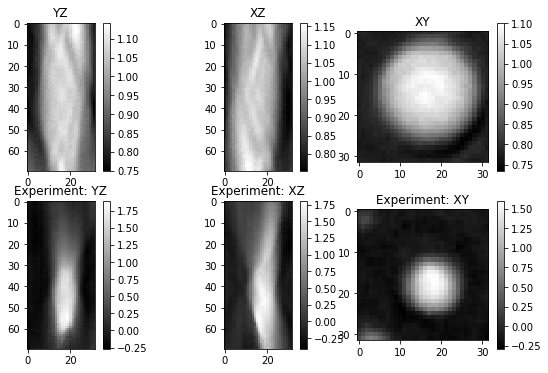

In [18]:
# add noise
myres_noise = myres + 0.001*np.random.randn(muscat.Nz,muscat.Nx,muscat.Ny)

plt.subplot(231)
plt.title('YZ'),plt.imshow(np.angle(myres_noise)[:,muscat.mysize[1]//2,:]), plt.colorbar()
plt.subplot(232)
plt.title('XZ'),plt.imshow(np.angle(myres_noise)[:,:,muscat.mysize[2]//2]), plt.colorbar()
plt.subplot(233)
plt.title('XY'),plt.imshow(np.angle(myres_noise)[muscat.mysize[0]//2,:,:]), plt.colorbar()

plt.subplot(234)
plt.title('Experiment: YZ'),plt.imshow(np.angle(matlab_val)[:,muscat.mysize[1]//2,:]), plt.colorbar()
plt.subplot(235)
plt.title('Experiment: XZ'),plt.imshow(np.angle(matlab_val)[:,:,muscat.mysize[2]//2]), plt.colorbar()
plt.subplot(236)
plt.title('Experiment: XY'),plt.imshow(np.angle(matlab_val)[muscat.mysize[0]//2,:,:]), plt.colorbar()
#data.save_timeseries(np.angle(matlab_val), 'droplet_meas_angle')
#data.save_timeseries(np.angle(myres), 'droplet_simu_angle')    

# Define Optimizer and Cost-function

Now load data which has been saved previously (Optional!)

In [ ]:
#%%
'''Regression + Regularization'''
tf_meas = tf.placeholder(dtype=tf.complex64, shape=muscat.mysize)
             
'''Define Cost-function'''
tf_tvloss = lambda_tv*reg.tf_total_variation_regularization(muscat.TF_obj)  #Alernatively total_variation
tf_posloss = lambda_neg*reg.posiminity(muscat.TF_obj, minval=0)
tf_negloss = lambda_pos*reg.posimaxity(muscat.TF_obj, maxval=.2)  
tf_fidelity = tf.reduce_sum(tf_helper.tf_abssqr(tf_meas - tf_fwd))

tf_loss = tf_fidelity +  tf_negloss + tf_posloss + tf_tvloss

 # data fidelity
# TV regularization
# Positivity Penalty          
# eventually Goods Roughness reg
          
          
'''Define Optimizer'''
tf_optimizer = tf.train.AdamOptimizer(my_learningrate)
tf_lossop = tf_optimizer.minimize(tf_loss)


# this is the initial guess of the reconstruction
init_guess = np.angle(np_meas) - np.min(np.angle(np_meas))
init_guess = init_guess/np.max(init_guess)*muscat.dn

''' Evaluate the model '''
sess = tf.Session()
sess.run(tf.global_variables_initializer())
sess.run(tf.assign(muscat.TF_obj, init_guess)) # assign abs of measurement as initial guess of 


Regularizer: Penalize Values less then 0
Regularizer: Penalize Values higher then 0.2


array([[[0.00505855, 0.00585442, 0.0053537 , ..., 0.00577383,
         0.00524947, 0.00575598],
        [0.00537951, 0.00541178, 0.0047304 , ..., 0.00549233,
         0.0054247 , 0.00626564],
        [0.00557854, 0.00540142, 0.00642429, ..., 0.00543032,
         0.00524949, 0.0057105 ],
        ...,
        [0.0056429 , 0.00697382, 0.00706871, ..., 0.00868675,
         0.00955298, 0.01035521],
        [0.00581071, 0.00710834, 0.00706191, ..., 0.00856903,
         0.00910828, 0.01035197],
        [0.0068533 , 0.00751915, 0.00795216, ..., 0.00700549,
         0.00732621, 0.00964682]],

       [[0.00413923, 0.00502043, 0.00538776, ..., 0.00568447,
         0.00549494, 0.00576532],
        [0.00577594, 0.00461982, 0.00429445, ..., 0.00572584,
         0.00522285, 0.00614755],
        [0.00560898, 0.00539659, 0.00631114, ..., 0.00545719,
         0.00542263, 0.00582783],
        ...,
        [0.00615065, 0.00654047, 0.00663823, ..., 0.00876264,
         0.00958357, 0.01028623],
        [0.0

# Optimize

In [ ]:
#%%
''' Optimize the model '''
print('Start optimizing')
mylosslist = []
for iterx in range(1,Niter):
    # try to optimize
    
    if(not np.mod(iterx, Ndisplay)):
        my_opt, my_res, my_loss, my_fidelity, my_negloss, my_posloss, my_tvloss =  \
            sess.run([tf_lossop, muscat.TF_obj, tf_loss, tf_fidelity, tf_negloss, tf_posloss, tf_tvloss], feed_dict={tf_meas:np_meas})
        
        #data.save_as_tif(np.squeeze(np.abs(my_res[:,muscat.mysize[1]//2,:])), 'res_xz', savepath)
        #data.save_as_tif(np.squeeze(np.abs(my_res[:,:,muscat.mysize[2]//2])), 'res_yz', savepath)
        #data.save_as_tif(np.squeeze(np.abs(my_res[muscat.mysize[0]//2,:,:])), 'res_xy', savepath)

        print('MY loss: @'+str(iterx)+': ' + str(my_loss) + ' - Fidelity: '+str(my_fidelity)+', Neg: '+str(my_negloss)+', Pos: '+str(my_posloss)+', TV: '+str(my_tvloss))        
        mylosslist.append(my_loss)
    else:
        sess.run([tf_lossop], feed_dict={tf_meas:np_meas})
        #plt.imshow(np.abs(my_res[:,50,:]))
        
# diplay the error over time
plt.title('Error/Cost-function'), plt.plot(np.array(mylosslist)), plt.show()


Start optimizing
MY loss: @10: 43037.664 - Fidelity: 26394.648, Neg: 2647.897, Pos: 13983.438, TV: 11.681409
MY loss: @20: 17326.914 - Fidelity: 11562.805, Neg: 813.15796, Pos: 4939.496, TV: 11.455249
MY loss: @30: 8759.409 - Fidelity: 6905.8926, Neg: 327.0937, Pos: 1515.0392, TV: 11.383664
MY loss: @40: 6062.1562 - Fidelity: 5170.927, Neg: 232.45583, Pos: 647.413, TV: 11.360402
MY loss: @50: 4371.507 - Fidelity: 3965.3984, Neg: 110.68577, Pos: 284.08817, TV: 11.334681
MY loss: @60: 5007.8804 - Fidelity: 4672.209, Neg: 105.30633, Pos: 219.03595, TV: 11.328926
MY loss: @70: 4304.5337 - Fidelity: 4035.918, Neg: 58.420288, Pos: 198.87051, TV: 11.324949
MY loss: @80: 4347.895 - Fidelity: 4229.0786, Neg: 36.264847, Pos: 71.2405, TV: 11.311161
MY loss: @90: 4553.027 - Fidelity: 4420.439, Neg: 46.838528, Pos: 74.43538, TV: 11.313971
MY loss: @100: 3847.917 - Fidelity: 3749.6782, Neg: 30.968876, Pos: 55.960674, TV: 11.309055
MY loss: @110: 6184.244 - Fidelity: 5999.8105, Neg: 48.92248, Pos: 12

# Display result

In [ ]:
#%% Display the results
is_display=True
myfwd, mymeas, my_res = sess.run([tf_fwd, tf_meas, muscat.TF_obj], feed_dict={tf_meas:np_meas})
        
if(is_display): plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(mymeas))**.2)[:,muscat.mysize[1]//2,:]), plt.colorbar(), plt.show()    
if(is_display): plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(mymeas))**.2)[muscat.mysize[0]//2,:,:]), plt.colorbar(), plt.show()   
if(is_display): plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(mymeas))**.2)[:,:,muscat.mysize[2]//2]), plt.colorbar(), plt.show()     
if(is_display): plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(myfwd))**.2)[:,muscat.mysize[1]//2,:]), plt.colorbar(), plt.show()
if(is_display): plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(myfwd))**.2)[muscat.mysize[0]//2,:,:]), plt.colorbar(), plt.show()    
if(is_display): plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(myfwd))**.2)[:,:,muscat.mysize[2]//2]), plt.colorbar(), plt.show()    
tf_helper.saveHDF5(np.abs(np.fft.fftshift(np.fft.fftn(myfwd))), 'FFT3D_FWD')

if(is_display): plt.title('XZ'),plt.imshow(np.abs(myfwd)[:,muscat.mysize[1]//2,:]), plt.colorbar(), plt.show()
if(is_display): plt.title('XZ'),plt.imshow(np.abs(myfwd)[:,:,muscat.mysize[2]//2]), plt.colorbar(), plt.show()
if(is_display): plt.title('XY'),plt.imshow(np.abs(myfwd)[muscat.mysize[0]//2,:,:]), plt.colorbar(), plt.show()

if(is_display): plt.title('XZ'),plt.imshow(np.angle(myfwd)[:,muscat.mysize[1]//2,:]), plt.colorbar(), plt.show()
if(is_display): plt.title('XZ'),plt.imshow(np.angle(myfwd)[:,:,muscat.mysize[2]//2]), plt.colorbar(), plt.show()
if(is_display): plt.title('XY'),plt.imshow(np.angle(myfwd)[muscat.mysize[0]//2,:,:]), plt.colorbar(), plt.show()


my_residual = tf_helper.abssqr(myfwd-mymeas)
if(is_display): plt.title('Residual: XZ'),plt.imshow(my_residual [:,muscat.mysize[1]//2,:]), plt.colorbar(), plt.show()
if(is_display): plt.title('Residual: XZ'),plt.imshow(my_residual [:,:,muscat.mysize[2]//2]), plt.colorbar(), plt.show()
if(is_display): plt.title('Residual: XY'),plt.imshow(my_residual [muscat.mysize[0]//2,:,:]), plt.colorbar(), plt.show()


if(is_display): plt.title('Result: XZ'),plt.imshow(my_res[:,muscat.mysize[1]//2,:]), plt.colorbar(), plt.show()
if(is_display): plt.title('Result: XZ'),plt.imshow(my_res[:,:,muscat.mysize[2]//2]), plt.colorbar(), plt.show()
if(is_display): plt.title('Result: XY'),plt.imshow(my_res[muscat.mysize[0]//2,:,:]), plt.colorbar(), plt.show()


#%% save the results
np.save(savepath+'/rec.npy', my_res)
 
tf_helper.saveHDF5(my_res, savepath+'Obj_Reconstruction')
tf_helper.saveHDF5(np_obj, savepath+'Obj_Orig')
tf_helper.saveHDF5(np.abs(np_meas), savepath+'Amplitude_abs')
tf_helper.saveHDF5(np.angle(np_meas), savepath+'Amplitude_angle')

# Save results

In [ ]:
#%% save the results
np.save(savepath+'/rec.npy', my_res)
 
tf_helper.saveHDF5(my_res, savepath+'/Obj_Reconstruction.h5')
tf_helper.saveHDF5(np.abs(np_meas), savepath+'/Amplitude_abs.h5')
tf_helper.saveHDF5(np.angle(np_meas), savepath+'/Amplitude_angle.h5')